### pip install pydotplus
### pip install graphviz
### pip install causalgraphicalmodels
### graphviz path 설정은 [링크](http://203.252.196.107/xe/referenceK/363) 첨부파일 참조

### 모든 내용은 다음의 [링크](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/) 참조하였음 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")

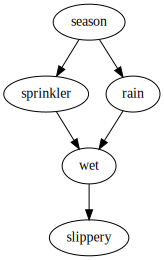

In [12]:
from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), ## to from순으로 작성
        ("season","sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

sprinkler.draw()

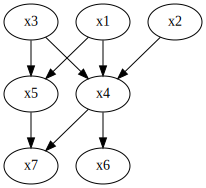

In [28]:
example = CausalGraphicalModel(
    nodes=['x1','x2','x3','x4','x5','x6','x7'],
    edges=[
        ("x1", "x4"), ## to from순으로 작성
        ("x1","x5"), 
        ("x2", "x4"),
        ("x3", "x4"), 
        ('x3', "x5"),
        ('x5', 'x7'),
        ('x4', 'x6'),
        ('x4', 'x7')
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
example.draw()

### get join probability distribution implied by causal graphical model

#### .get_distribution()

In [6]:
print(sprinkler.get_distribution())

P(season)P(sprinkler|season)P(rain|season)P(wet|rain,sprinkler)P(slippery|wet)


## example

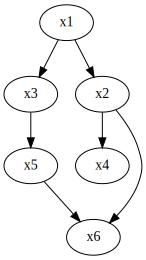

In [7]:
path = CausalGraphicalModel(
    nodes = ["x1", "x2", "x3", "x4", "x5","x6"],
    edges = [("x1", "x2"), ("x1", "x3"), ("x3", "x5"), ("x5", "x6"),("x2", "x4"),("x2", "x6")]
)

path.draw()

In [10]:
print("Are x1 and x4 conditional independent when conditioning on x2? {} "
      .format(path.is_d_separated("x1", "x4", {"x2"})))

print("Are x2 and x3 conditional independent when conditioning on x1 and x6? {} "
      .format(path.is_d_separated("x2", "x3", {"x1", "x6"})))

Are x1 and x4 conditional independent when conditioning on x2? True 
Are x2 and x3 conditional independent when conditioning on x1 and x6? False 


### 모든 independence relationship 

#### 'A'와 'B'는 given {"C"}일 때 conditional independence 

In [11]:
path.get_all_independence_relationships()

[('x4', 'x1', {'x2'}),
 ('x4', 'x1', {'x2', 'x5'}),
 ('x4', 'x1', {'x2', 'x3'}),
 ('x4', 'x1', {'x2', 'x6'}),
 ('x4', 'x1', {'x2', 'x3', 'x5'}),
 ('x4', 'x1', {'x2', 'x5', 'x6'}),
 ('x4', 'x1', {'x2', 'x3', 'x6'}),
 ('x4', 'x1', {'x2', 'x3', 'x5', 'x6'}),
 ('x4', 'x5', {'x3'}),
 ('x4', 'x5', {'x2'}),
 ('x4', 'x5', {'x1'}),
 ('x4', 'x5', {'x2', 'x3'}),
 ('x4', 'x5', {'x1', 'x3'}),
 ('x4', 'x5', {'x2', 'x6'}),
 ('x4', 'x5', {'x1', 'x2'}),
 ('x4', 'x5', {'x2', 'x3', 'x6'}),
 ('x4', 'x5', {'x1', 'x2', 'x3'}),
 ('x4', 'x5', {'x1', 'x2', 'x6'}),
 ('x4', 'x5', {'x1', 'x2', 'x3', 'x6'}),
 ('x4', 'x3', {'x2'}),
 ('x4', 'x3', {'x1'}),
 ('x4', 'x3', {'x2', 'x5'}),
 ('x4', 'x3', {'x1', 'x5'}),
 ('x4', 'x3', {'x2', 'x6'}),
 ('x4', 'x3', {'x1', 'x2'}),
 ('x4', 'x3', {'x2', 'x5', 'x6'}),
 ('x4', 'x3', {'x1', 'x5', 'x6'}),
 ('x4', 'x3', {'x1', 'x2', 'x5'}),
 ('x4', 'x3', {'x1', 'x2', 'x6'}),
 ('x4', 'x3', {'x1', 'x2', 'x5', 'x6'}),
 ('x4', 'x6', {'x2'}),
 ('x4', 'x6', {'x2', 'x5'}),
 ('x4', 'x6', {'x2

## Average Causal Effect (Average Treatment Effect)

#### x를 제외한 나머지 변수들은 linear relationship 이고 x는 bernoulli distributed

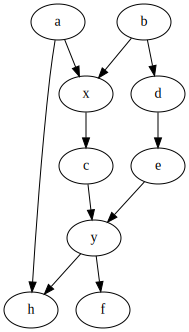

In [19]:
from causalgraphicalmodels.examples import big_csm

big_csm.cgm.draw()

In [21]:
big_csm.sample(5)

,b,d,e,a,x,c,y,h,f
0,-1.502892,2.686320,5.938064,-0.203544,0,-1.745619,-11.031013,-15.413380,-7.558461
1,-0.389485,0.603440,2.604401,-1.215746,0,0.547341,-0.167823,-2.268106,1.085829
2,0.804434,0.603775,0.387613,2.109343,0,-0.454957,-1.993553,2.582329,-0.251607
3,-0.669532,-0.306654,-1.216426,-0.214331,0,-0.257420,1.120645,1.094459,-0.646486
4,-0.727717,1.535460,2.895092,0.001631,0,0.409315,-1.160895,-1.909792,-2.185055


#### Y에 대한 X의 Average causal effect or Average treatment effect
#### adjust하는 set에 따라 Y에 대한 X의 ACE(ATE) 확인

In [32]:
from causalinference import CausalModel

def estimate_ate(dataset, adjustment_set=None, method="matching"):
    
    """
    dataset: pd.DateFrame
        dataframe of observations
        
    adjustment_set: iterable of variables or None
    
    method: str
        adjustment method to use.    
    """
    
    if adjustment_set is None:
        y0 = dataset.loc[lambda df: df.x == 0].y.mean()
        y1 = dataset.loc[lambda df: df.x == 1].y.mean()
        
        y0_var = dataset.loc[lambda df: df.x == 0].y.var()
        y1_var = dataset.loc[lambda df: df.x == 1].y.var()
        
        y0_n = dataset.loc[lambda df: df.x == 0].shape[0]
        y1_n = dataset.loc[lambda df: df.x == 1].shape[0]
        
        return {
            "ate": y1 - y0,
            "ate_se": 2 * np.sqrt(y0_var/y0_n + y1_var/y1_n)
        }

    cm = CausalModel(
        Y=dataset.y.values, 
        D=dataset.x.values, 
        X=dataset[adjustment_set].values
    )

    cm.est_via_ols() #Treatment effect estimates : OLS
    # estimates average treatment effects using least squares
    cm.est_via_matching()
    # estimates average treatment effects using nearest-neighborhood matching 
    
    results = {
        "ate": cm.estimates[method]["ate"],
        "ate_se": cm.estimates[method]["ate_se"]
    }

    return results

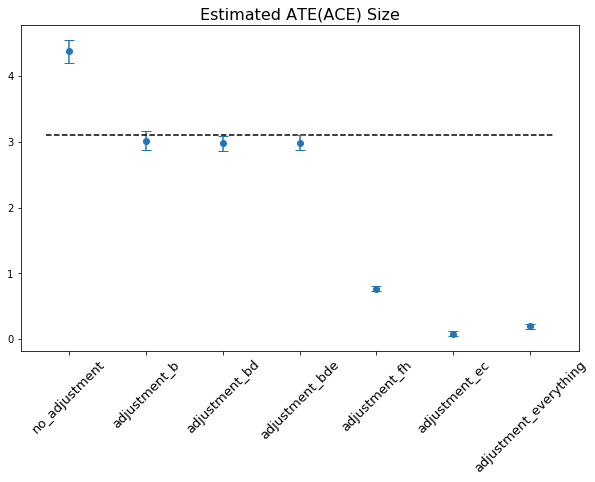

In [42]:
n_samples = 10000

ds = big_csm.sample(n_samples)

# this allows us to generate samples from an interventional distribution
# where the value of X is assigned randomly as in an A/B test.
ds_intervention = (
    big_csm
    .do("x")
    .sample(
        n_samples=10000, 
        set_values={"x": np.random.binomial(p=0.5, n=1, size=10000)})
)

true_ate = estimate_ate(ds_intervention)["ate"]

# generate results for a number of different adjustment sets
results = {
    "no_adjustment": estimate_ate(ds),
    "adjustment_b": estimate_ate(ds, ["b"]),
    "adjustment_bd": estimate_ate(ds, ["b", "d"]),
    "adjustment_bde": estimate_ate(ds, ["b", "d", "e"]),
    "adjustment_fh": estimate_ate(ds, ["f", "h"]),
    "adjustment_ec": estimate_ate(ds, ["e", "c"]),
    "adjustment_everything": estimate_ate(ds, ["a", "b", "c", "d", "e", "f", "h"]),

}

# plot the results
x_label = list(results.keys())
x = np.arange(len(x_label))
y = [results[l]["ate"] for l in x_label]
yerr = [results[l]["ate_se"] for l in x_label]

plt.figure(figsize=(10,6))
plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
plt.xticks(x, x_label, rotation=45, fontsize=13)
plt.title("Estimated ATE(ACE) Size", fontsize=16)
xmin, xmax = plt.xlim()
plt.hlines(true_ate, xmin, xmax, linestyles="dashed")

#### adjustment variable 값에 대해 X와 Y의 연관성을 계산 (adjustment variable에 대한 조정, adjustment variable에 대한 통제) 
#### valid adjustment는 값이 true value 근처에 있다. 